In [36]:
try:
    # Check if already mounted
    import os
    assert os.path.exists('/content/drive/MyDrive')
except:
    from google.colab import drive
    drive.mount('/content/drive')


In [10]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import libraries
import pandas as pd
import os
import re

# Step 3: Define folder path
folder_path = '/content/drive/MyDrive/GEE_Exports'

# Step 4: List all CSV files (excluding the final_year_cleaned.csv)
all_files = os.listdir(folder_path)
remote_files = [f for f in all_files if f.endswith('.csv') and f != 'final_production_data.csv']

# Step 5: Load and tag each file with its year from filename
remote_df_list = []
for file in remote_files:
    match = re.search(r'(\\d{4})', file)
    if match:
        year = int(match.group(1))
        df = pd.read_csv(os.path.join(folder_path, file))
        df['Year'] = year
        remote_df_list.append(df)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# Step 2: Import libraries
import pandas as pd
import os
import re

# Step 3: Define folder path
folder_path = '/content/drive/MyDrive/GEE_Exports'

# Step 4: Verify folder exists
if not os.path.exists(folder_path):
    raise FileNotFoundError(f"Folder not found: {folder_path}")

# Step 5: List all CSV files (excluding the production file)
all_files = os.listdir(folder_path)
remote_files = [f for f in all_files if f.endswith('.csv') and f != 'final_production_data.csv']

# Step 6: Load and tag each file with its year from filename (2004–2022)
remote_df_list = []
required_cols = ['District', 'Year', 'NDVI', 'EVI', 'GNDVI', 'S2REP', 'WDBI', 'Yield (Tonne/Hectare)']

print(remote_files)
for file in remote_files:
    match = re.search(r'(\d{4})', file)
    if match:
        year = int(match.group(1))
        if 2004 <= year <= 2022:
            df = pd.read_csv(os.path.join(folder_path, file))
            df['Year'] = year
            #print(f"\n📂 File: {file}")
            #print("📊 Columns:", df.columns.tolist())  # list of column names
            remote_df_list.append(df)
# Step 7: Concatenate all remote sensing data
remote_df = pd.concat(remote_df_list, ignore_index=True)

# Step 8: Rename column for consistency
remote_df.rename(columns={'ADM2_NAME': 'District'}, inplace=True)

# Step 9: Load production data
production_df = pd.read_csv(os.path.join(folder_path, 'final_production_data.csv'))

# Step 10: Extract starting year from 'Year' column in production data
#production_df['Year'] = production_df['Year'].str.extract(r'(\\d{4})').astype(int)
print('production_df',production_df.columns.tolist())
# Step 11: Merge on District and Year
merged_df = pd.merge(production_df, remote_df, on=['District', 'Year'], how='inner')

# Step 12: Save the merged dataset
#merged_df.to_csv(os.path.join(folder_path, 'merged_with_remote_sensing.csv'), index=False)

# Step 13: Preview
merged_df[['District', 'Year', 'NDVI', 'EVI', 'GNDVI', 'S2REP', 'WDBI', 'Yield (Tonne/Hectare)']].head(10)
merged_df.to_csv(os.path.join(folder_path, 'merged_with_remote_sensing.csv'),
                 columns=required_cols, index=False)


['MP_Wheat_Indices_2007.csv', 'MP_Wheat_Indices_2005.csv', 'MP_Wheat_Indices_2009.csv', 'MP_Wheat_Indices_2008.csv', 'MP_Wheat_Indices_2006.csv', 'MP_Wheat_Indices_2010.csv', 'MP_Wheat_Indices_2011.csv', 'MP_Wheat_Indices_2024.csv', 'MP_Wheat_Indices_2022.csv', 'MP_Wheat_Indices_2012.csv', 'MP_Wheat_Indices_2023.csv', 'MP_Wheat_Indices_2021.csv', 'MP_Wheat_Indices_2020.csv', 'MP_Wheat_Indices_2013.csv', 'MP_Wheat_Indices_2019.csv', 'MP_Wheat_Indices_2018.csv', 'MP_Wheat_Indices_2014.csv', 'MP_Wheat_Indices_2015.csv', 'MP_Wheat_Indices_2017.csv', 'MP_Wheat_Indices_2016.csv']
production_df ['State', 'District', 'Year', 'Area (Hectare)', 'Production (Tonnes)', 'Yield (Tonne/Hectare)']


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import os

# Path in Colab
folder_path = '/content/drive/MyDrive/GEE_Exports'
file_path = os.path.join(folder_path, 'merged_with_remote_sensing.csv')

# 1. Load your merged dataset
df = pd.read_csv(file_path)

# 2. Select features (X) and target (y)
features = ['NDVI', 'EVI', 'GNDVI', 'S2REP', 'WDBI']
target = 'Yield (Tonne/Hectare)'

X = df[features]
y = df[target]

# 3. Handle missing values (if any)
X = X.fillna(X.mean())
y = y.fillna(y.mean())

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5. Define and train SVR model
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X_train, y_train)

# 6. Predictions
y_pred = svr_model.predict(X_test)

# 7. Evaluate performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Removed squared=False

print("📊 Model Performance:")
print("R² Score:", r2)
print("RMSE:", rmse)

# 8. Save predictions to CSV inside same folder
results = X_test.copy()
results['Actual_Yield'] = y_test.values
results['Predicted_Yield'] = y_pred
results.to_csv(os.path.join(folder_path, "svr_predictions.csv"), index=False)

print("✅ Predictions saved to:", os.path.join(folder_path, "svr_predictions.csv"))

📊 Model Performance:
R² Score: -0.6522787307394515
RMSE: 1.339513116392079
✅ Predictions saved to: /content/drive/MyDrive/GEE_Exports/svr_predictions.csv


In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import os

folder_path = '/content/drive/MyDrive/GEE_Exports'
file_path = os.path.join(folder_path, 'merged_with_remote_sensing.csv')

# Load dataset
df = pd.read_csv(file_path)

features = ['NDVI', 'EVI', 'GNDVI', 'S2REP', 'WDBI']
target = 'Yield (Tonne/Hectare)'

X = df[features]
y = df[target]

X = X.fillna(X.mean())
y = y.fillna(y.mean())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# SVR pipeline with scaling
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR())
])

# Hyperparameter tuning
param_grid = {
    "svr__kernel": ["rbf", "poly", "linear"],
    "svr__C": [1, 10, 100, 1000],
    "svr__gamma": ["scale", 0.1, 0.01, 0.001],
    "svr__epsilon": [0.01, 0.1, 0.2, 0.5]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("🔎 Best Params:", grid.best_params_)
print("📊 R² Score:", r2)
print("📉 RMSE:", rmse)

🔎 Best Params: {'svr__C': 10, 'svr__epsilon': 0.5, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
📊 R² Score: 0.30875525041045937
📉 RMSE: 0.8664055730200331


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1045
[LightGBM] [Info] Number of data points in the train set: 625, number of used features: 5
[LightGBM] [Info] Start training from score 2.692000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

,Model,CV_R2_mean,CV_R2_std,CV_RMSE_mean,CV_RMSE_std,CV_MAE_mean,CV_MAE_std,Test_R2,Test_RMSE,Test_MAE,Test_MAPE,Test_sMAPE
0,MLP,-0.121081,0.619369,1.118607,0.256645,0.796267,0.058725,0.293377,0.875990,0.695847,31.891922,26.769003
1,RandomForest,0.233154,0.093098,0.954493,0.051191,0.752010,0.044267,0.214145,0.923797,0.722877,32.955237,27.570280
2,Ridge,0.234252,0.037353,0.956091,0.040675,0.765358,0.033921,0.200204,0.931955,0.745328,35.656130,28.952708
3,LinearRegression,0.233806,0.037159,0.956360,0.040344,0.765508,0.033712,0.200128,0.931999,0.745342,35.653097,28.952851
4,GradientBoosting,0.225263,0.073617,0.960355,0.045436,0.764668,0.034752,0.188498,0.938751,0.735662,33.875561,28.167781
5,XGBoost,0.155706,0.102309,1.000986,0.043905,0.800988,0.046912,0.183098,0.941868,0.734095,33.765735,28.153124
6,KNN,0.199007,0.063587,0.976868,0.040833,0.763485,0.029232,0.135453,0.968946,0.766726,34.473045,29.251321
7,SVR_RBF,0.164695,0.080723,0.998200,0.068015,0.770897,0.051968,0.116505,0.979506,0.733061,33.053906,28.394040
8,LightGBM,0.087902,0.074702,1.042195,0.042098,0.827286,0.025032,0.049285,1.016086,0.804495,36.343246,30.890612
9,Lasso,-0.004865,0.005430,1.096200,0.054365,0.897573,0.035563,-0.023623,1.054327,0.875197,42.564490,33.220663


Saved summary to: /content/drive/MyDrive/GEE_Exports/model_comparison_summary.csv


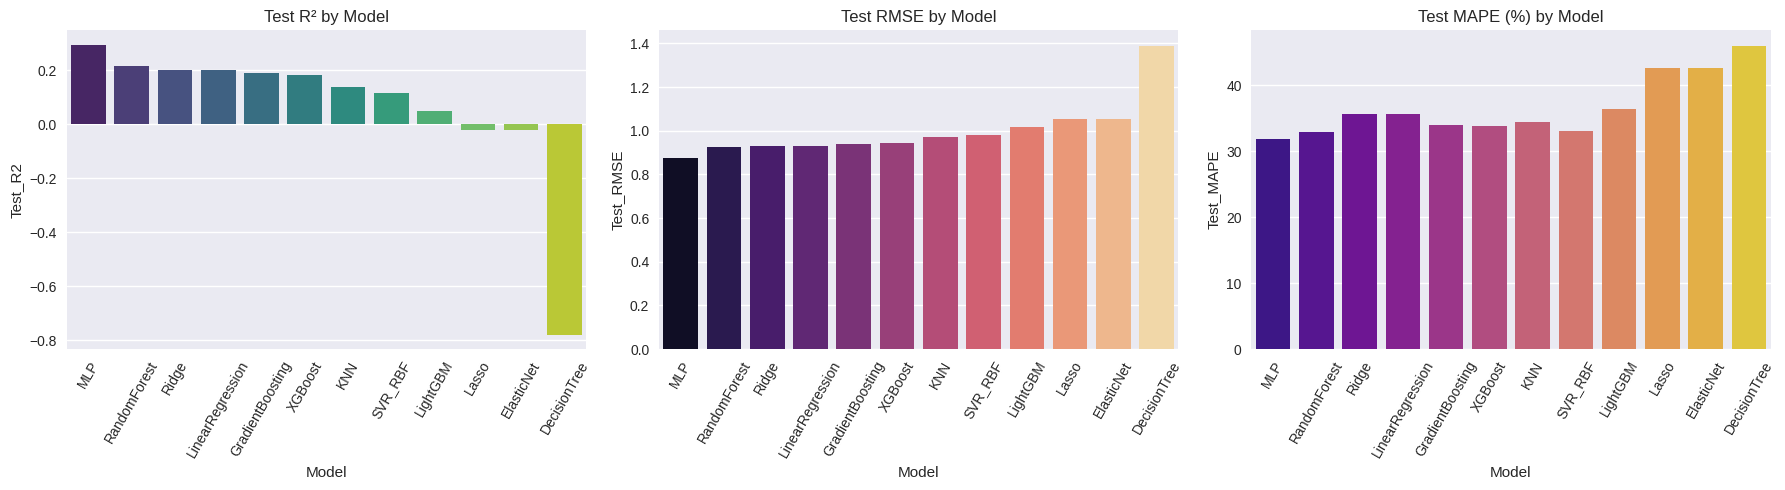

Best model (by Test R²): MLP


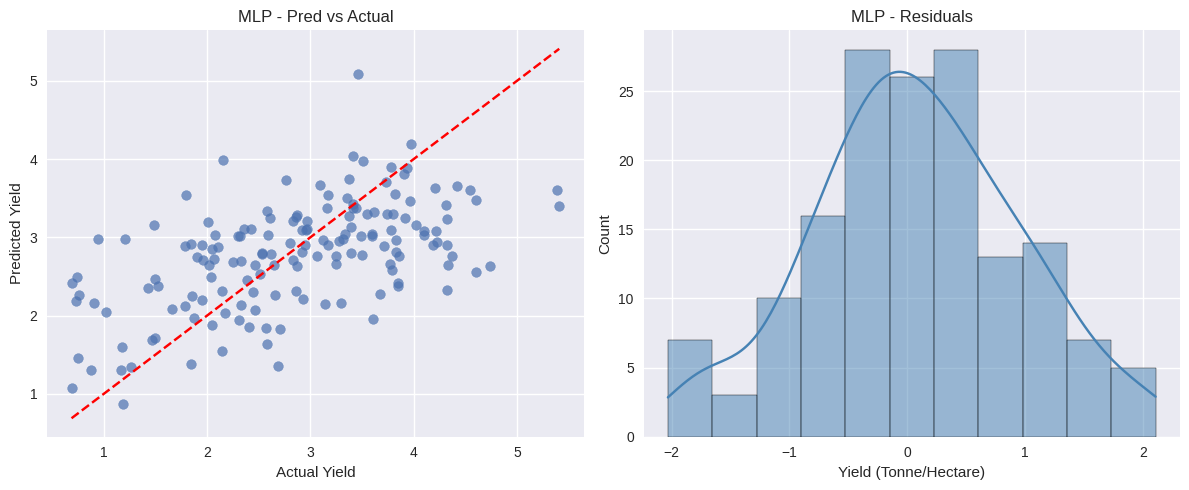

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits

=== Tuned Models (Test metrics) ===


,Model,BestParams,Test_R2,Test_RMSE,Test_MAPE
0,MLP (tuned),"{'reg__regressor__learning_rate_init': 0.001, ...",0.305325,0.868553,32.915197
1,RandomForest (tuned),"{'reg__n_estimators': 300, 'reg__min_samples_s...",0.264626,0.893634,33.466638


Saved tuned summary to: /content/drive/MyDrive/GEE_Exports/model_tuned_summary.csv
Saved best model to: /content/drive/MyDrive/GEE_Exports/best_model__MLP_(tuned).joblib


In [37]:
# ======================
# 0) Optional installs
# ======================
# Uncomment the next lines in Colab if you want to try boosting libraries
# !pip -q install xgboost lightgbm catboost

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Optional models (skip gracefully if not installed)
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

try:
    from catboost import CatBoostRegressor
    HAS_CAT = True
except Exception:
    HAS_CAT = False

from joblib import dump

# ================
# 1) Configuration
# ================
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 5

folder_path = '/content/drive/MyDrive/GEE_Exports'
file_path = os.path.join(folder_path, 'merged_with_remote_sensing.csv')

# Set your features and target here
features = ['NDVI', 'EVI', 'GNDVI', 'S2REP', 'WDBI']
target = 'Yield (Tonne/Hectare)'

# =================
# 2) Load the data
# =================
df = pd.read_csv(file_path)

# Basic sanity check
missing_cols = [c for c in features + [target] if c not in df.columns]
if missing_cols:
    raise ValueError(f"Columns not in CSV: {missing_cols}")

X = df[features].copy()
y = df[target].copy()

# =========================
# 3) Train / test split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# =========================
# 4) Metrics & utilities
# =========================
def mape(y_true, y_pred, eps=1e-8):
    # Avoid div-by-zero; mask zeros
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.abs(y_true) > eps
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def smape(y_true, y_pred, eps=1e-8):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    mask = denom > eps
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denom[mask]) * 100

def evaluate_on_test(model, X_tr, y_tr, X_te, y_te, name):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    return {
        "model": name,
        "R2_test": r2_score(y_te, y_pred),
        "RMSE_test": np.sqrt(mean_squared_error(y_te, y_pred)),
        "MAE_test": mean_absolute_error(y_te, y_pred),
        "MAPE_test": mape(y_te, y_pred),
        "sMAPE_test": smape(y_te, y_pred),
        "y_pred": y_pred  # for plotting later (only for best)
    }

# ==============================================
# 5) Define models (with safe preprocessing)
# - Using SimpleImputer + StandardScaler
# - Wrap regressor in TransformedTargetRegressor when helpful
# ==============================================
numeric_preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Models that benefit from target scaling
def ttr(reg):
    return TransformedTargetRegressor(
        regressor=reg, transformer=StandardScaler()
    )

models = {}

# Linear family
models["LinearRegression"] = Pipeline([
    ("prep", numeric_preprocess),
    ("reg", ttr(LinearRegression()))
])

models["Ridge"] = Pipeline([
    ("prep", numeric_preprocess),
    ("reg", ttr(Ridge(random_state=RANDOM_STATE)))
])

models["Lasso"] = Pipeline([
    ("prep", numeric_preprocess),
    ("reg", ttr(Lasso(random_state=RANDOM_STATE, max_iter=10000)))
])

models["ElasticNet"] = Pipeline([
    ("prep", numeric_preprocess),
    ("reg", ttr(ElasticNet(random_state=RANDOM_STATE, max_iter=10000)))
])

# Instance-based
models["KNN"] = Pipeline([
    ("prep", numeric_preprocess),
    ("reg", ttr(KNeighborsRegressor(n_neighbors=5)))
])

# Trees / Ensembles (no need to scale target)
tree_preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())  # not strictly required; can help with outliers
])

models["DecisionTree"] = Pipeline([
    ("prep", tree_preprocess),
    ("reg", DecisionTreeRegressor(random_state=RANDOM_STATE))
])

models["RandomForest"] = Pipeline([
    ("prep", tree_preprocess),
    ("reg", RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1))
])

models["GradientBoosting"] = Pipeline([
    ("prep", tree_preprocess),
    ("reg", GradientBoostingRegressor(random_state=RANDOM_STATE))
])

# Kernel methods
models["SVR_RBF"] = Pipeline([
    ("prep", numeric_preprocess),
    ("reg", ttr(SVR(kernel="rbf", C=100, epsilon=0.1, gamma="scale")))
])

# Neural network
models["MLP"] = Pipeline([
    ("prep", numeric_preprocess),
    ("reg", ttr(MLPRegressor(hidden_layer_sizes=(64, 32), activation="relu", random_state=RANDOM_STATE, max_iter=5000)))
])

# Optional boosters
if HAS_XGB:
    models["XGBoost"] = Pipeline([
        ("prep", tree_preprocess),
        ("reg", XGBRegressor(
            n_estimators=600, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
            random_state=RANDOM_STATE, tree_method="hist", objective="reg:squarederror", n_jobs=-1
        ))
    ])

if HAS_LGBM:
    models["LightGBM"] = Pipeline([
        ("prep", tree_preprocess),
        ("reg", LGBMRegressor(
            n_estimators=800, num_leaves=63, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
            random_state=RANDOM_STATE, n_jobs=-1
        ))
    ])

if HAS_CAT:
    models["CatBoost"] = Pipeline([
        ("prep", tree_preprocess),
        ("reg", CatBoostRegressor(
            iterations=1000, depth=6, learning_rate=0.05, loss_function="RMSE",
            random_seed=RANDOM_STATE, verbose=False
        ))
    ])

# ===========================================
# 6) Cross-validated evaluation + Test eval
# ===========================================
scoring = {
    "R2": "r2",
    "negRMSE": "neg_root_mean_squared_error",
    "negMAE": "neg_mean_absolute_error"
}

cv = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

rows = []
test_predictions = {}

for name, model in models.items():
    # Cross-validate on train split only (avoids test leakage)
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

    row = {
        "Model": name,
        "CV_R2_mean": np.mean(cv_results["test_R2"]),
        "CV_R2_std": np.std(cv_results["test_R2"]),
        "CV_RMSE_mean": -np.mean(cv_results["test_negRMSE"]),
        "CV_RMSE_std": np.std(-cv_results["test_negRMSE"]),
        "CV_MAE_mean": -np.mean(cv_results["test_negMAE"]),
        "CV_MAE_std": np.std(-cv_results["test_negMAE"]),
    }

    # Evaluate on held-out test
    test_eval = evaluate_on_test(model, X_train, y_train, X_test, y_test, name)
    row.update({
        "Test_R2": test_eval["R2_test"],
        "Test_RMSE": test_eval["RMSE_test"],
        "Test_MAE": test_eval["MAE_test"],
        "Test_MAPE": test_eval["MAPE_test"],
        "Test_sMAPE": test_eval["sMAPE_test"],
    })

    rows.append(row)
    test_predictions[name] = test_eval["y_pred"]

results = pd.DataFrame(rows).sort_values(by="Test_R2", ascending=False).reset_index(drop=True)
print("\n=== Model Comparison (sorted by Test R²) ===")
display(results)

# Save summary
summary_path = os.path.join(folder_path, "model_comparison_summary.csv")
results.to_csv(summary_path, index=False)
print(f"Saved summary to: {summary_path}")

# ===========================================
# 7) Plots: metrics & best model diagnostics
# ===========================================
plt.style.use("seaborn-v0_8")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.barplot(data=results, x="Model", y="Test_R2", ax=axes[0], palette="viridis")
axes[0].set_title("Test R² by Model"); axes[0].tick_params(axis='x', rotation=60)

sns.barplot(data=results, x="Model", y="Test_RMSE", ax=axes[1], palette="magma")
axes[1].set_title("Test RMSE by Model"); axes[1].tick_params(axis='x', rotation=60)

sns.barplot(data=results, x="Model", y="Test_MAPE", ax=axes[2], palette="plasma")
axes[2].set_title("Test MAPE (%) by Model"); axes[2].tick_params(axis='x', rotation=60)
plt.tight_layout()
plt.show()

# Best model name
best_name = results.iloc[0]["Model"]
print(f"Best model (by Test R²): {best_name}")

# Diagnostics for best model
best_pred = test_predictions[best_name]
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(y_test, best_pred, alpha=0.7)
ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax[0].set_xlabel("Actual Yield"); ax[0].set_ylabel("Predicted Yield"); ax[0].set_title(f"{best_name} - Pred vs Actual")

resid = y_test - best_pred
sns.histplot(resid, kde=True, ax=ax[1], color="steelblue")
ax[1].set_title(f"{best_name} - Residuals")
plt.tight_layout()
plt.show()

# ===========================================
# 8) Optional: quick tuning of top models
# ===========================================
TOP_N = 2  # tune top N models by Test R2
top_models = results.head(TOP_N)["Model"].tolist()

param_spaces = {
    "RandomForest": {
        "reg__n_estimators": [300, 500, 800, 1200],
        "reg__max_depth": [None, 6, 10, 16],
        "reg__min_samples_split": [2, 5, 10],
        "reg__min_samples_leaf": [1, 2, 4],
        "reg__max_features": ["auto", "sqrt", 0.8],
    },
    "GradientBoosting": {
        "reg__n_estimators": [300, 600, 1000],
        "reg__learning_rate": [0.01, 0.05, 0.1],
        "reg__max_depth": [2, 3, 4, 5],
        "reg__subsample": [0.7, 0.85, 1.0],
    },
    "SVR_RBF": {
        "reg__regressor__C": np.logspace(-1, 3, 8),
        "reg__regressor__gamma": ["scale", 1e-3, 1e-2, 1e-1],
        "reg__regressor__epsilon": [0.01, 0.05, 0.1, 0.2, 0.5],
    },
    "MLP": {
        "reg__regressor__hidden_layer_sizes": [(128,64), (64,32), (128,64,32)],
        "reg__regressor__alpha": [1e-5, 1e-4, 1e-3],
        "reg__regressor__learning_rate_init": [1e-3, 3e-3, 1e-2],
    },
}

if HAS_XGB:
    param_spaces["XGBoost"] = {
        "reg__n_estimators": [400, 800, 1200],
        "reg__max_depth": [4, 6, 8],
        "reg__learning_rate": [0.01, 0.05, 0.1],
        "reg__subsample": [0.7, 0.85, 1.0],
        "reg__colsample_bytree": [0.6, 0.8, 1.0],
    }

if HAS_LGBM:
    param_spaces["LightGBM"] = {
        "reg__n_estimators": [600, 1000, 1500],
        "reg__num_leaves": [31, 63, 127],
        "reg__learning_rate": [0.01, 0.05, 0.1],
        "reg__subsample": [0.7, 0.85, 1.0],
        "reg__colsample_bytree": [0.6, 0.8, 1.0],
    }

if HAS_CAT:
    param_spaces["CatBoost"] = {
        "reg__depth": [4, 6, 8],
        "reg__learning_rate": [0.01, 0.05, 0.1],
        "reg__iterations": [600, 1000, 1500]
    }

tuned_results = []
best_tuned_model = None
best_tuned_name = None
best_tuned_r2 = -np.inf

for name in top_models:
    if name not in param_spaces:
        print(f"Skipping tuning for {name} (no param space defined).")
        continue

    base_model = models[name]
    param_dist = param_spaces[name]

    tuner = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=25,
        cv=cv,
        scoring="r2",
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )
    tuner.fit(X_train, y_train)

    y_pred = tuner.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape_val = mape(y_test, y_pred)

    tuned_results.append({
        "Model": name + " (tuned)",
        "BestParams": tuner.best_params_,
        "Test_R2": r2,
        "Test_RMSE": rmse,
        "Test_MAPE": mape_val
    })

    if r2 > best_tuned_r2:
        best_tuned_r2 = r2
        best_tuned_model = tuner.best_estimator_
        best_tuned_name = name + " (tuned)"

tuned_df = pd.DataFrame(tuned_results)
if not tuned_df.empty:
    print("\n=== Tuned Models (Test metrics) ===")
    display(tuned_df.sort_values("Test_R2", ascending=False))

    # Save tuned summary
    tuned_summary_path = os.path.join(folder_path, "model_tuned_summary.csv")
    tuned_df.to_csv(tuned_summary_path, index=False)
    print(f"Saved tuned summary to: {tuned_summary_path}")

# ============================
# 9) Save best final model
# ============================
final_model_name = best_tuned_name if best_tuned_model is not None else best_name
final_model = best_tuned_model if best_tuned_model is not None else models[best_name].fit(X_train, y_train)

model_path = os.path.join(folder_path, f"best_model__{final_model_name.replace(' ', '_')}.joblib")
dump(final_model, model_path)
print(f"Saved best model to: {model_path}")


**xgboost**

In [38]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

import xgboost as xgb


In [42]:
# Load your dataset
folder_path = '/content/drive/MyDrive/GEE_Exports'
file_path = os.path.join(folder_path, 'merged_with_remote_sensing.csv')

# Set your features and target here
features = ['NDVI', 'EVI', 'GNDVI', 'S2REP', 'WDBI']
target = 'Yield (Tonne/Hectare)'
df = pd.read_csv(file_path)
# Define target and features
target = "Yield (Tonne/Hectare)"  # Replace with your target column
X = df.drop(columns=[target])
y = df[target]


In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [44]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


In [45]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])


In [46]:
param_grid = {
    'regressor__n_estimators': [200, 500, 800],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__subsample': [0.7, 0.8, 1.0],
    'regressor__colsample_bytree': [0.7, 0.8, 1.0]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='r2',
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'regressor__colsample_bytree': 0.7, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 500, 'regressor__subsample': 0.7}


In [47]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"Test R²: {r2:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAPE: {mape:.2f}%")


Test R²: 0.743
Test RMSE: 0.528
Test MAPE: 16.39%


## XGBoost + MLP + RandomForest

In [48]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

import xgboost as xgb


In [72]:
# Load your dataset
folder_path = '/content/drive/MyDrive/GEE_Exports'
file_path = os.path.join(folder_path, 'merged_with_remote_sensing.csv')

# Set your features and target here
# features = ['NDVI', 'EVI', 'GNDVI', 'S2REP', 'WDBI','Year']
# target = 'Yield (Tonne/Hectare)'
# df = pd.read_csv(file_path)

# # Define target and features
# target = "Yield (Tonne/Hectare)"  # Replace with your target column
# X = df[features] # Select only the specified features for X
# y = df[target]


target = "Yield (Tonne/Hectare)"  # Replace with your actual target column
X = df.drop(columns=[target])
y = df[target]

# ----------------------------
# 3️⃣ Train-Test Split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [73]:
X

,District,Year,NDVI,EVI,GNDVI,S2REP,WDBI
0,Anuppur,2005,0.331607,0.244925,0.404039,515.380061,0.474141
1,Anuppur,2006,0.335356,0.209334,0.410059,608.546564,0.441706
2,Anuppur,2007,0.311141,0.233029,0.389309,570.099145,0.469026
3,Anuppur,2008,0.320399,0.197239,0.399428,579.485210,0.442619
4,Anuppur,2010,0.353518,0.218582,0.430657,577.609355,0.418274
...,...,...,...,...,...,...,...
777,Vidisha,2018,0.389685,0.249408,0.439526,755.494458,0.440978
778,Vidisha,2019,0.372781,0.241231,0.423867,728.617719,0.461010
779,Vidisha,2020,0.454193,0.299665,0.474157,846.391098,0.411148
780,Vidisha,2021,0.402021,-196324.585142,0.436758,759.409829,0.438200


In [74]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


In [75]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42
)


In [76]:
estimators = [
    ('xgb', xgb_model),
    ('rf', rf_model),
    ('mlp', mlp_model)
]

stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=xgb.XGBRegressor(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.05,
        random_state=42
    ),
    n_jobs=-1
)


In [77]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('stacking', stack_model)
])


In [78]:
# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"Stacked Model Test R²: {r2:.3f}")
print(f"Stacked Model Test RMSE: {rmse:.3f}")
print(f"Stacked Model Test MAPE: {mape:.2f}%")

Stacked Model Test R²: 0.733
Stacked Model Test RMSE: 0.538
Stacked Model Test MAPE: 16.27%


## **hyperparameter tuning using Optuna**

In [79]:
pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 11.3 MB/s eta 0:00:00


In [83]:
import os
import pandas as pd
import numpy as np
import optuna

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

import xgboost as xgb

# ----------------------------
# 1️⃣ Load Data
# ----------------------------
folder_path = '/content/drive/MyDrive/GEE_Exports'
file_path = os.path.join(folder_path, 'merged_with_remote_sensing.csv')

df = pd.read_csv(file_path)

target = "Yield (Tonne/Hectare)"  # replace with your actual target column
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----------------------------
# 2️⃣ Preprocessing
# ----------------------------
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# ----------------------------
# 3️⃣ Define Optuna Objective
# ----------------------------
def objective(trial):
    # Base models hyperparameters
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=trial.suggest_int('xgb_n_estimators', 200, 800),
        max_depth=trial.suggest_int('xgb_max_depth', 3, 8),
        learning_rate=trial.suggest_loguniform('xgb_lr', 0.01, 0.2),
        subsample=trial.suggest_float('xgb_subsample', 0.6, 1.0),
        colsample_bytree=trial.suggest_float('xgb_colsample', 0.6, 1.0),
        random_state=42,
        n_jobs=-1
    )

    rf_model = RandomForestRegressor(
        n_estimators=trial.suggest_int('rf_n_estimators', 200, 800),
        max_depth=trial.suggest_int('rf_max_depth', 3, 15),
        min_samples_split=trial.suggest_int('rf_min_samples_split', 2, 10),
        random_state=42,
        n_jobs=-1
    )

    mlp_model = MLPRegressor(
        hidden_layer_sizes=(trial.suggest_int('mlp_hidden1', 50, 150),
                            trial.suggest_int('mlp_hidden2', 25, 100)),
        activation='relu',
        solver='adam',
        learning_rate_init=trial.suggest_loguniform('mlp_lr', 0.0005, 0.01),
        max_iter=500,
        random_state=42
    )

    # Final estimator
    final_xgb = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=trial.suggest_int('final_n_estimators', 100, 400),
        max_depth=trial.suggest_int('final_max_depth', 3, 6),
        learning_rate=trial.suggest_loguniform('final_lr', 0.01, 0.2),
        random_state=42,
        n_jobs=-1
    )

    # Stacking
    stack_model = StackingRegressor(
        estimators=[('xgb', xgb_model), ('rf', rf_model), ('mlp', mlp_model)],
        final_estimator=final_xgb,
        n_jobs=-1
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('stacking', stack_model)
    ])

    # 5-fold CV using R²
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1)

    return scores.mean()

# ----------------------------
# 4️⃣ Run Optuna Study
# ----------------------------
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)  # you can increase trials for better results

print("Best trial:", study.best_trial.params)

# ----------------------------
# 5️⃣ Train Best Model
# ----------------------------
best_params = study.best_trial.params

# Construct base models with best params
best_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_params['xgb_n_estimators'],
    max_depth=best_params['xgb_max_depth'],
    learning_rate=best_params['xgb_lr'],
    subsample=best_params['xgb_subsample'],
    colsample_bytree=best_params['xgb_colsample'],
    random_state=42,
    n_jobs=-1
)

best_rf = RandomForestRegressor(
    n_estimators=best_params['rf_n_estimators'],
    max_depth=best_params['rf_max_depth'],
    min_samples_split=best_params['rf_min_samples_split'],
    random_state=42,
    n_jobs=-1
)

best_mlp = MLPRegressor(
    hidden_layer_sizes=(best_params['mlp_hidden1'], best_params['mlp_hidden2']),
    activation='relu',
    solver='adam',
    learning_rate_init=best_params['mlp_lr'],
    max_iter=500,
    random_state=42
)

best_final = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_params['final_n_estimators'],
    max_depth=best_params['final_max_depth'],
    learning_rate=best_params['final_lr'],
    random_state=42,
    n_jobs=-1
)

best_stack = StackingRegressor(
    estimators=[('xgb', best_xgb), ('rf', best_rf), ('mlp', best_mlp)],
    final_estimator=best_final,
    n_jobs=-1
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('stacking', best_stack)
])

pipeline.fit(X_train, y_train)

# ----------------------------
# 6️⃣ Evaluate
# ----------------------------
y_pred = pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"Optuna Stacked Model Test R²: {r2:.3f}")
print(f"Optuna Stacked Model Test RMSE: {rmse:.3f}")
print(f"Optuna Stacked Model Test MAPE: {mape:.2f}%")


[I 2025-08-22 08:36:09,599] A new study created in memory with name: no-name-43ae7d9f-f960-49d2-96fc-9224e84bd4f9
[I 2025-08-22 08:37:59,160] Trial 0 finished with value: 0.6550484253776315 and parameters: {'xgb_n_estimators': 587, 'xgb_max_depth': 3, 'xgb_lr': 0.11286401293900801, 'xgb_subsample': 0.9986211930291661, 'xgb_colsample': 0.8716497948150469, 'rf_n_estimators': 623, 'rf_max_depth': 7, 'rf_min_samples_split': 10, 'mlp_hidden1': 140, 'mlp_hidden2': 61, 'mlp_lr': 0.00491632284424642, 'final_n_estimators': 393, 'final_max_depth': 6, 'final_lr': 0.04256692728902527}. Best is trial 0 with value: 0.6550484253776315.
[I 2025-08-22 08:39:42,437] Trial 1 finished with value: 0.689694234534185 and parameters: {'xgb_n_estimators': 226, 'xgb_max_depth': 6, 'xgb_lr': 0.016824860105200155, 'xgb_subsample': 0.9920380252468687, 'xgb_colsample': 0.877751247704448, 'rf_n_estimators': 567, 'rf_max_depth': 8, 'rf_min_samples_split': 9, 'mlp_hidden1': 92, 'mlp_hidden2': 52, 'mlp_lr': 0.002751838

Best trial: {'xgb_n_estimators': 472, 'xgb_max_depth': 8, 'xgb_lr': 0.03600484936163953, 'xgb_subsample': 0.8635513036883333, 'xgb_colsample': 0.6072357749324786, 'rf_n_estimators': 797, 'rf_max_depth': 11, 'rf_min_samples_split': 6, 'mlp_hidden1': 103, 'mlp_hidden2': 32, 'mlp_lr': 0.0005242084698170583, 'final_n_estimators': 101, 'final_max_depth': 3, 'final_lr': 0.03543703937194076}
Optuna Stacked Model Test R²: 0.775
Optuna Stacked Model Test RMSE: 0.494
Optuna Stacked Model Test MAPE: 15.38%
